In [1]:
#---------------------------------------------------------------------Risk Classification---------------------------------------------------------------

# important data columns :-
# policy id
# age
# gender
# policy_type
# annual_income
# property_age
# Claim_History
# fraudulent_claim
# premium_amount
# claim_amount
# risk_score

# create dataset
# np.random.seed(42)
# n = 100000

# # Base data
# df = pd.DataFrame({
#     "Policy_ID": [f"POL{100000 + i}" for i in range(n)],
#     "Customer_Age": np.random.randint(18, 70, size=n),
#     "Gender": np.random.choice(["Male", "Female"], size=n, p=[0.50, 0.50]),
#     "Policy_Type": np.random.choice(["Health", "Auto", "Life", "Property"], size=n, p=[0.3, 0.3, 0.2, 0.2]),
#     "Annual_Income": np.random.normal(60000, 20000, size=n).clip(15000, 200000).round(2),
#     "Property_Age": np.random.randint(0, 20, size=n),
#     "Claim_History": np.random.poisson(lam=1.2, size=n)
# })

# # Risk Score
# conditions = [
#     (df["Claim_History"] >= 3) | (df["Vehicle_or_Property_Age"] > 15),(df["Claim_History"] == 2),
#     (df["Claim_History"] <= 1) & (df["Vehicle_or_Property_Age"] < 10)
# ]
# choices = ["High", "Medium", "Low"]
# df["Risk_Score"] = np.select(conditions, choices, default="High")

# # Premium Calculation
# premium_base = {"Health": 300, "Auto": 500, "Life": 400, "Property": 450}
# df["Premium_Amount"] = df.apply(
#     lambda x: premium_base[x["Policy_Type"]] + (x["Customer_Age"] - 18) * 2 +
#               (100 if x["Risk_Score"] == "High" else (50 if x["Risk_Score"] == "Medium" else 0)),axis=1).round(2)

# # Claim Amount
# df["Claim_Amount"] = df.apply(
#     lambda x: np.random.normal(loc=5000 if x["Risk_Score"] == "Low" else (15000 if x["Risk_Score"] == "Medium" else 30000),scale=3000),axis=1
# ).clip(0, 50000).round(2)

# # Fraudulent Claim (target)
# fraud_prob = df["Risk_Score"].map({"Low": 0.05, "Medium": 0.15, "High": 0.4})
# fraud_prob = fraud_prob.fillna(0.1).clip(0, 1)
# df["fraudulent_claim"] = np.random.binomial(1, fraud_prob)

# Final dataset
# df.head()
# df.to_csv("C:/Users/91801/Desktop/Insurance Project/dataset/insurance_data.csv", index=False)


# In this project, I saw that machine learning models worked well on small synthetic datasets with limitted features.
# But when I used large synthetic data, the models didn’t perform well unless the data was created to behave like real world data.
# When I made the synthetic data more realistic by using real patterns and relationships—the models gave better results. 
# This shows that good quality synthetic data is very important when real data isn’t available.

In [2]:
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score,classification_report

In [3]:
df = pd.read_csv("C:/Users/91801/Desktop/Insurance Project/dataset/insurance_data.csv")
df.head()

,Policy_ID,Customer_Age,Gender,Policy_Type,Annual_Income,Property_Age,Claim_History,Risk_Score,Premium_Amount,Claim_Amount,fraudulent_claim
0,POL100000,56,Female,Health,91465.94,8,2,Medium,426,14134.62,0
1,POL100001,69,Female,Property,99375.03,3,1,Low,552,4075.14,0
2,POL100002,46,Male,Health,79249.71,7,1,Low,356,1382.87,0
3,POL100003,32,Male,Auto,78744.75,15,1,High,628,24902.32,0
4,POL100004,60,Male,Life,51210.11,19,2,High,584,29411.28,1


In [4]:
# make columns lowercase
df.columns = df.columns.str.lower()

In [5]:
# change the dtype for columns
df[["gender", "policy_type", "risk_score"]] = df[["gender", "policy_type", "risk_score"]].astype(object)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   policy_id         100000 non-null  object 
 1   customer_age      100000 non-null  int64  
 2   gender            100000 non-null  object 
 3   policy_type       100000 non-null  object 
 4   annual_income     100000 non-null  float64
 5   property_age      100000 non-null  int64  
 6   claim_history     100000 non-null  int64  
 7   risk_score        100000 non-null  object 
 8   premium_amount    100000 non-null  int64  
 9   claim_amount      100000 non-null  float64
 10  fraudulent_claim  100000 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 8.4+ MB


In [7]:
df.describe()

,customer_age,annual_income,property_age,claim_history,premium_amount,claim_amount,fraudulent_claim
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,43.500270,60005.893630,9.509020,1.200650,519.592040,19161.815148,0.242510
std,14.970933,19691.895922,5.772903,1.092209,96.429391,11647.972285,0.428603
min,18.000000,15000.000000,0.000000,0.000000,300.000000,0.000000,0.000000
25%,31.000000,46513.822500,4.000000,0.000000,448.000000,7053.422500,0.000000
50%,43.000000,59922.690000,10.000000,1.000000,526.000000,20915.970000,0.000000
75%,56.000000,73378.797500,15.000000,2.000000,596.000000,29958.755000,0.000000
max,69.000000,152334.530000,19.000000,10.000000,702.000000,41740.810000,1.000000


In [8]:
df.describe(include="object")

,policy_id,gender,policy_type,risk_score
count,100000,100000,100000,100000
unique,100000,2,4,3
top,POL199960,Female,Auto,High
freq,1,50201,30084,49653


<Axes: xlabel='customer_age', ylabel='Count'>

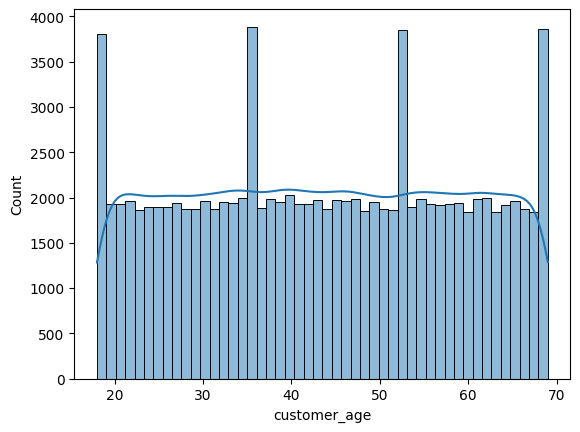

In [9]:
#-----------------------------------------------------------EDA(Eploratory Data Analysis)-----------------------------------------------------------

sns.histplot(df["customer_age"], kde=True)

<Axes: xlabel='gender', ylabel='count'>

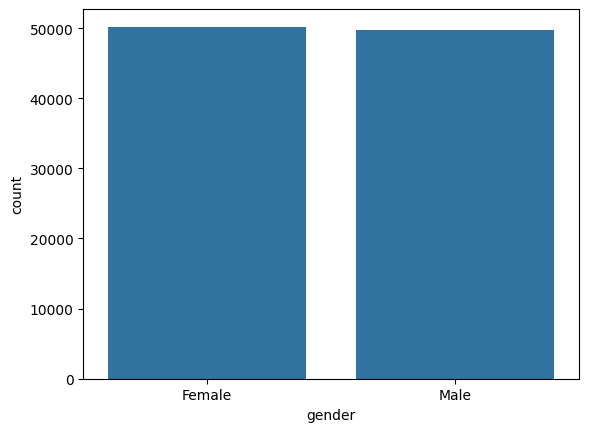

In [10]:
sns.countplot(data=df, x=df["gender"])

<Axes: xlabel='policy_type', ylabel='count'>

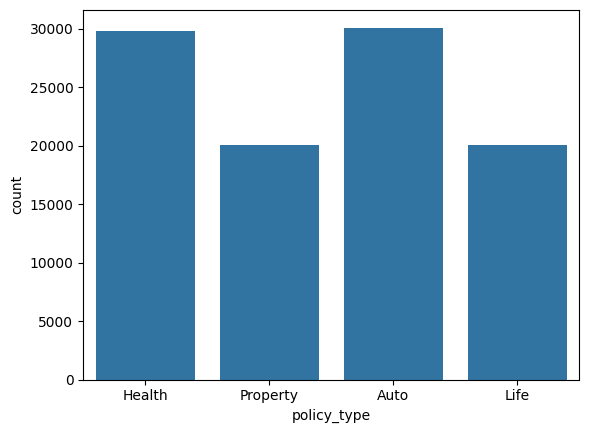

In [11]:
sns.countplot(data=df, x="policy_type")

<Axes: xlabel='annual_income', ylabel='Count'>

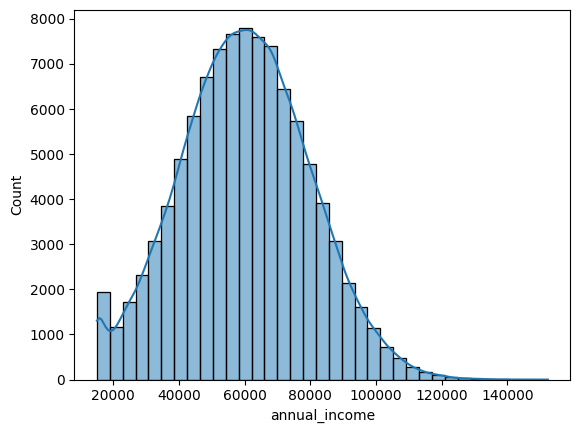

In [12]:
sns.histplot(df["annual_income"], bins=35, kde=True)

<Axes: xlabel='property_age', ylabel='Count'>

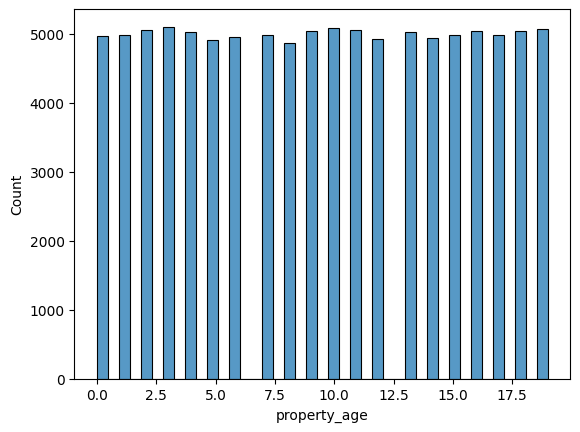

In [13]:
sns.histplot(df["property_age"])

<Axes: xlabel='premium_amount', ylabel='Count'>

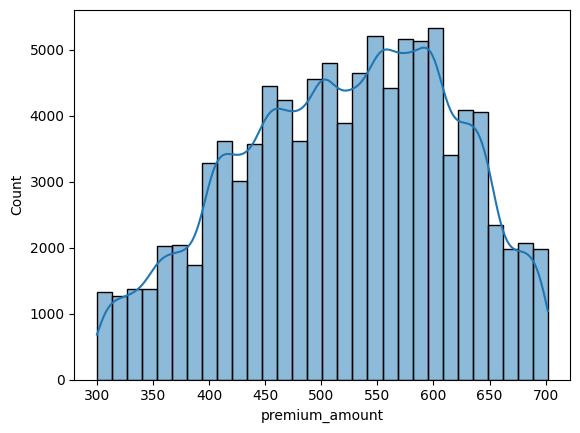

In [14]:
sns.histplot(df["premium_amount"], bins=30, kde=True)

<Axes: xlabel='claim_amount', ylabel='Count'>

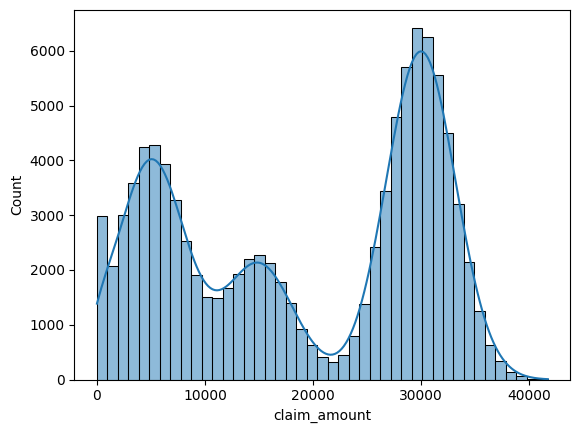

In [15]:
sns.histplot(df["claim_amount"], kde=True)

<Axes: xlabel='risk_score', ylabel='count'>

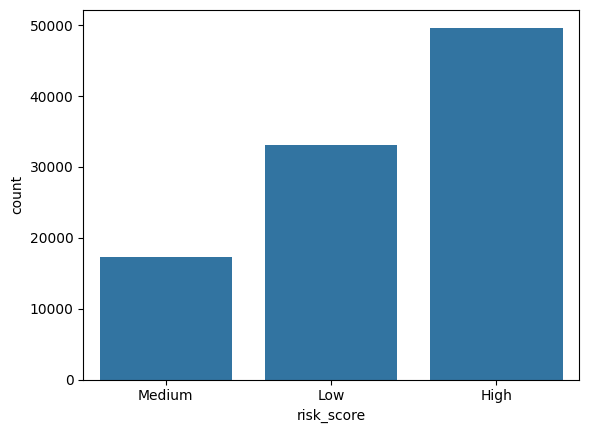

In [16]:
sns.countplot(x=df["risk_score"])

<Axes: xlabel='risk_score', ylabel='count'>

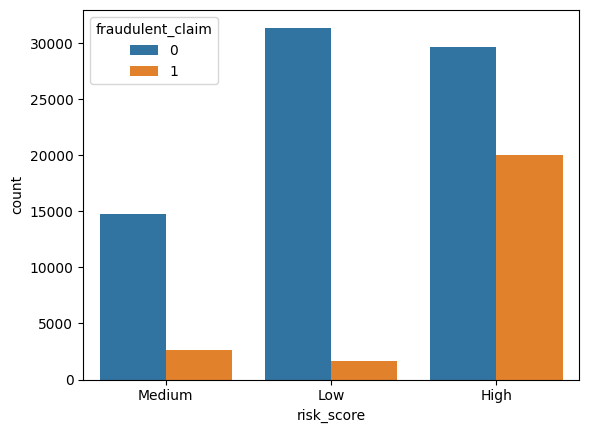

In [17]:
sns.countplot(data=df, x="risk_score", hue="fraudulent_claim")

<Axes: xlabel='policy_type', ylabel='count'>

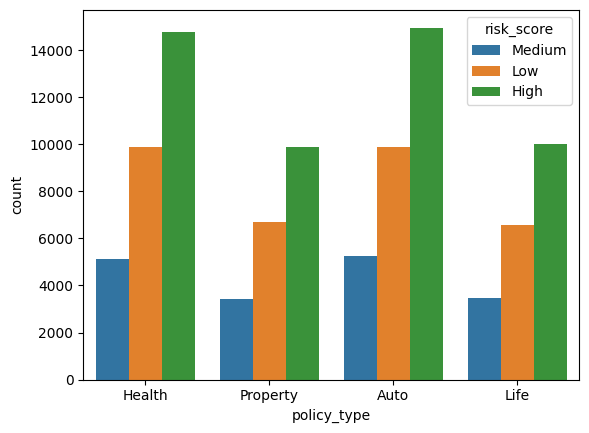

In [18]:
sns.countplot(data=df, x="policy_type", hue="risk_score")

<Axes: xlabel='risk_score', ylabel='annual_income'>

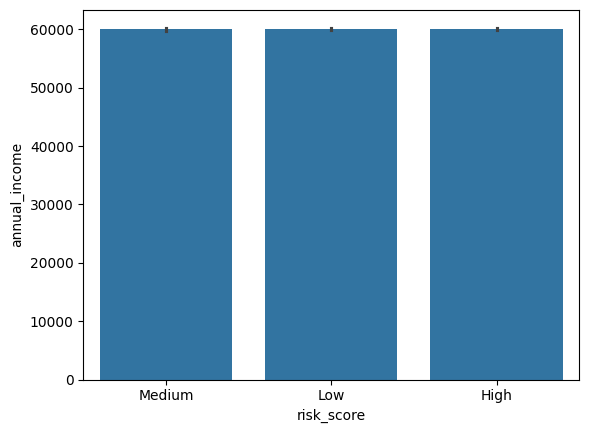

In [19]:
sns.barplot(data=df, x="risk_score", y="annual_income")

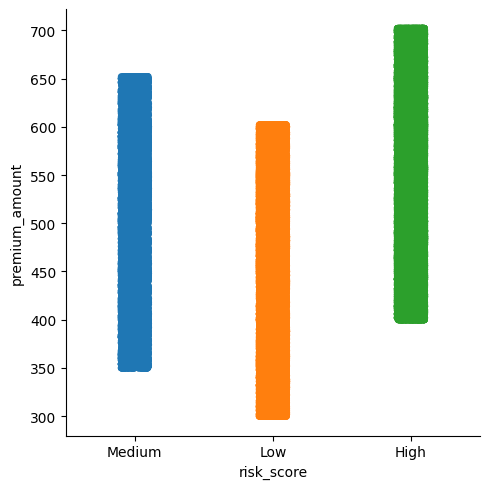

In [20]:
sns.catplot(data=df, x="risk_score", y="premium_amount", hue="risk_score")

<Axes: xlabel='claim_amount', ylabel='Count'>

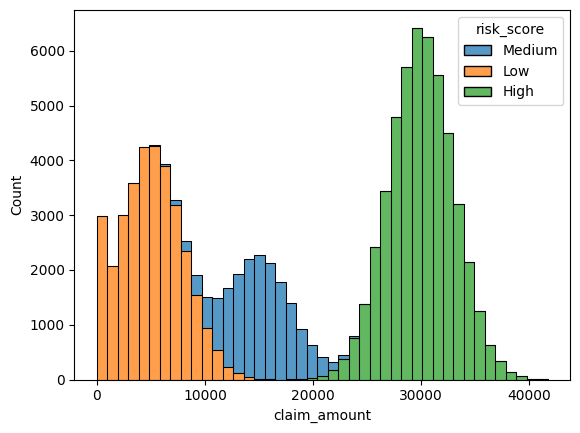

In [21]:
sns.histplot(data=df, x="claim_amount", hue="risk_score", multiple="stack")

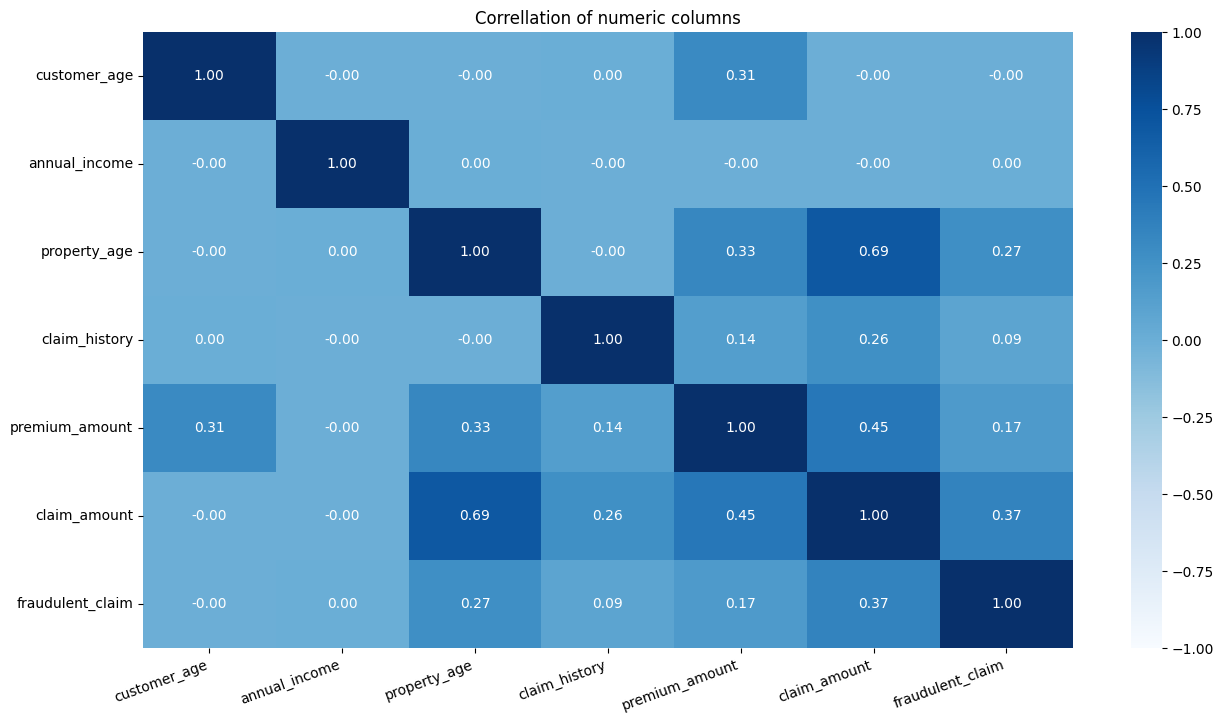

In [22]:
# if claim amount is increase the chance to made a farudluent claim that mean positive corrlation
# if claim amount is high premium amount is also high that mean positive correlation
# if claim amount is high fruadelent claim is also high that mean positive correlation
# if property age is high claim ammount will high that mean positive correlation
# if age is high then fraudulent claim is low that mean negative correlation

plt.figure(figsize=(15,8))
sns.heatmap(df.select_dtypes(include="number").corr(), annot=True, fmt=".2f", vmin=-1, vmax=1,cmap="Blues")
plt.title("Correllation of numeric columns")
plt.xticks(rotation=20,ha="right")
plt.show()

In [23]:
#---------------------------------------------------------------Data Preprocessing----------------------------------------------------------------------

df.isnull().sum()

policy_id           0
customer_age        0
gender              0
policy_type         0
annual_income       0
property_age        0
claim_history       0
risk_score          0
premium_amount      0
claim_amount        0
fraudulent_claim    0
dtype: int64

In [24]:
# One Hot Encoding
encode = df[["gender", "policy_type"]]
one_hot_encode = pd.get_dummies(encode,columns=["gender", "policy_type"], drop_first=True).astype(int)

In [25]:
# Label Encoding
df["risk_score"] = LabelEncoder().fit_transform(df["risk_score"])

In [26]:
# drop columns & insert the one hot encoded columns
feature = df.drop(columns=["gender", "policy_type"],inplace=True)
feature = pd.concat([df,one_hot_encode], axis=1)

In [27]:
# feature selection
x = feature.drop(columns=["policy_id", "risk_score"])
y = feature["risk_score"]

In [28]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [29]:
# feature scaling
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

In [30]:
model = RandomForestClassifier()

In [31]:
model.fit(x_train_scaled, y_train)

RandomForestClassifier()

In [32]:
y_pred = model.predict(x_test_scaled)

In [33]:
# evaluate the model using metrics
print(f"accuracy score : {accuracy_score(y_test,y_pred):.2f}")
print(f"precision score : {precision_score(y_test,y_pred, average='micro'):.2f}")
print(f"recall score : {recall_score(y_test,y_pred, average='micro'):.2f}")
print(f"f1 score : {f1_score(y_test, y_pred, average='micro'):.2f}")
print(classification_report(y_test, y_pred))

accuracy score : 1.00
precision score : 1.00
recall score : 1.00
f1 score : 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9922
           1       1.00      1.00      1.00      6634
           2       1.00      1.00      1.00      3444

    accuracy                           1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000



In [34]:
check = scaler.transform([[69, 99375.03, 3, 1, 552, 4075.14, 0, 0, 0, 0, 1]])
model.predict(check)

C:\Users\91801\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


array([1])

In [35]:
model = Pipeline([
    ("scaler", scaler),
    ("model", model)
])
joblib.dump(model, "C:/Users/91801/Desktop/Insurance Project/models/risk_classification.pkl")

['C:/Users/91801/Desktop/Insurance Project/models/risk_classification.pkl']

In [36]:
model = joblib.load("C:/Users/91801/Desktop/Insurance Project/models/risk_classification.pkl")
new_data = [[69, 99375.03, 3, 1, 552, 4075.14, 0, 0, 0, 0, 1]]
prediction = model.predict(new_data)

print("Prediction:", prediction)

Prediction: [1]


C:\Users\91801\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
